# Research: Industrial machine anomaly detection

**Objectives:** 

1. Study the dataset available, its format, presence of missing values, etc... 
2. Understand the instances of the data, its range of values, possible correlations, etc...
3. Extract features from the data

**About the data:** 
In the raw data available, there are 40 measurement samples, which is labeled as **Before** or **After** the maintenance
procedure. Given the nature of this problem, the number of samples is considerably small, which makes the training of a
robust and reliable model more difficult - and the challenge more attractive. On the other hand, the number of samples for
each class is equal, which is a sign that we don't have to deal with unbalanced classes (generally, that is the rule for
real cases). Each sample is a unique `.csv` file.


In [1]:
# Configuration for documentation
save_fig = False
figure_saving_folder = '../docs/figures'

Importing the libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
from scipy import signal

from yaml import safe_load

Importing the YAML file data_catalog

In [3]:
data_catalog_path = './config/catalog.yml'

with open(data_catalog_path) as f:
    data_catalog = safe_load(f)

Importing the file with labels

In [4]:
labels = pd.read_csv('../{}'.format(data_catalog['machine_data_labels']['filepath']))
print('Labels available: ', labels.label.unique())
print('Number of missing values: ', labels.label.isna().sum())
print('\n')
print('Head of series labels: ')
labels.head()

Labels available:  ['Before' 'After']
Number of missing values:  0


Head of series labels: 


,label
0,Before
1,Before
2,Before
3,Before
4,Before


Importing the files with signal data.

As indicated in the YAML catalog file, the files with the signal data are in the `data/raw` folder, and they are constituted of several .csv files, enumerated from 01 to 40, each one for an unique measurement. By opening any of those files, one can observe that each measurement file has 3 columns, that is three channels of captured data (each for one sensor). 

So, our intention here is to load all those data into a single pd.DataFrame. For that, we create two functions: one to load one single file, and other to load a list of files.


In [5]:
def load_instance_file(filepath, filename, columns_names):
    
    full_filepath = filepath.format(filename)
    df = pd.read_csv('../{}'.format(full_filepath), names=columns_names)
    
    return df

def load_instance_set_files(instance_catalog, labels):
    
    dfs = []
    
    filepath = instance_catalog['filepath']
    columns_names = instance_catalog['columns']
    
    initial_value = int(instance_catalog['name_value_range'][0])
    final_value = int(instance_catalog['name_value_range'][1])     
        
    for i in range(initial_value, final_value + 1):
        
        df_ = load_instance_file(filepath, i, columns_names)
        df_['label'] = labels.iloc[i-1]['label']
        df_['sample'] = i
        df_['sample_index'] = df_.index.tolist()
        df_ = df_.set_index(['sample', 'sample_index'])
        dfs.append(df_)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)
    
    return df


Finally, loading the signals data.

In [6]:
data = load_instance_set_files(data_catalog['machine_data_instances'], labels)

data.head()

ch1       ch2       ch3   label
sample sample_index                                      
1      0            -3.211087 -0.564731  0.006844  Before
       1            -3.184189 -0.557148  0.009476  Before
       2            -3.182325 -0.551987  0.009119  Before
       3            -3.225936 -0.538765  0.000923  Before
       4            -3.233682 -0.529483 -0.007393  Before

Checking the data type of each columns.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2800000 entries, (1, 0) to (40, 69999)
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ch1     float64
 1   ch2     float64
 2   ch3     float64
 3   label   object 
dtypes: float64(3), object(1)
memory usage: 101.4+ MB


Checking for missing values.

In [8]:
data[['ch1', 'ch2', 'ch3']].isna().sum()

ch1    0
ch2    0
ch3    0
dtype: int64

For luck, we have no missing data here.

Checking for the range of values of each channel (for both Before and After maintenance scenarios)

In [9]:
data.describe()

,ch1,ch2,ch3
count,2.800000e+06,2.800000e+06,2.800000e+06
mean,-2.227967e-02,-2.044513e-02,-5.230628e-05
std,2.156970e+00,6.356138e-01,3.243971e-03
min,-5.187278e+00,-5.262302e+00,-2.517569e-01
25%,-1.534575e+00,-2.640694e-01,-1.575242e-03
50%,-6.479168e-01,-1.071016e-01,-1.735749e-05
75%,1.620665e+00,7.510626e-02,1.496626e-03
max,5.263454e+00,5.262361e+00,2.750578e-01


It can be observed that all three channels presents a mean and median near zero. The minimum and maximum values for the first two channels are similar, and seems to be also simetric. What differs them, however, is the standard deviation, which presents a considerably higher value for the ch1. The third channel have an amplitude that is approximately the half from the first two channels. It also has the smaller value of std. 

Now, let's see the proportion of each class in the dataset.

In [10]:
data['label'].value_counts()/len(data)

Before    0.5
After     0.5
Name: label, dtype: float64

Great! The data is ballanced between the two classes.

Now, let's that a look in the data. First, we plot all measurements data for a first look.
So, plotting all the data.

Text(0.5, 1.0, 'All the data')

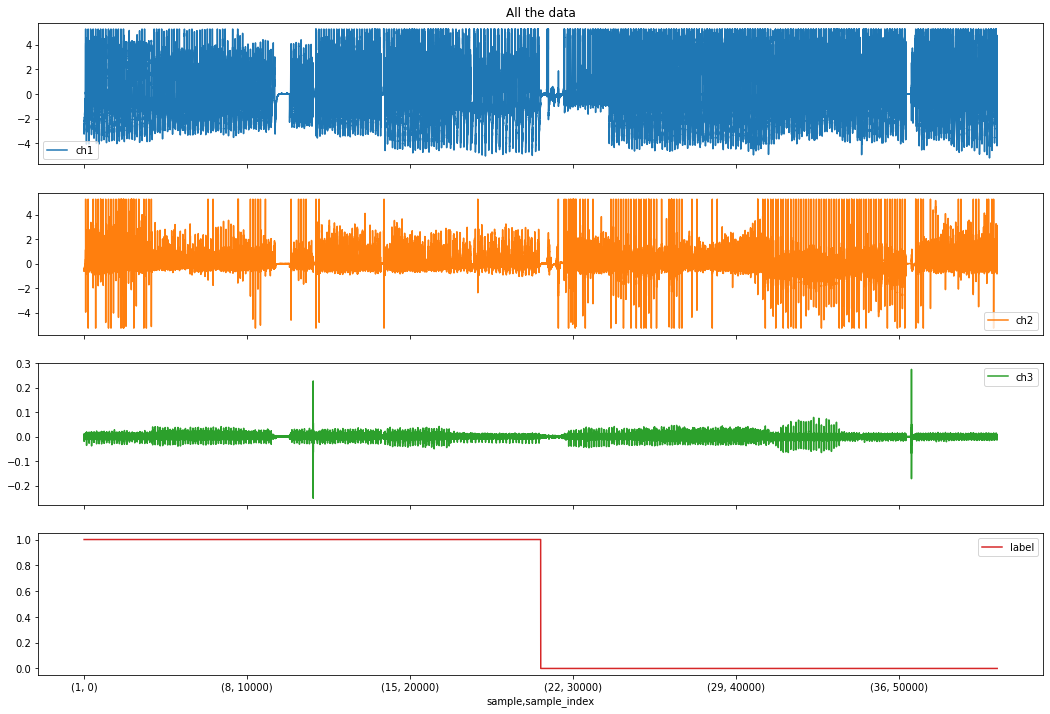

In [11]:
data_p = data.copy()
data_p['label'] = [1 if label == 'Before' else 0 for label in data_p['label']]

axs = data_p.plot(subplots=True, figsize=(18,12))
axs[0].set_title('All the data')

We see that the observations made for the summary table are confirmed here. All channels have mean approximetly zero. The first channel presents higher dispersion for both before and after scenarios. The second channel normally presents more positive values for before labels. And the third channels have the smaller amplitude (that means that the maximum and minimum obtained are probably outliers), and there is no apparent difference between the before and after labels.

Now, let's plot just one sample for before and after, just to check.

Plotting a sample for **before**.

Text(0.5, 1.0, 'Before')

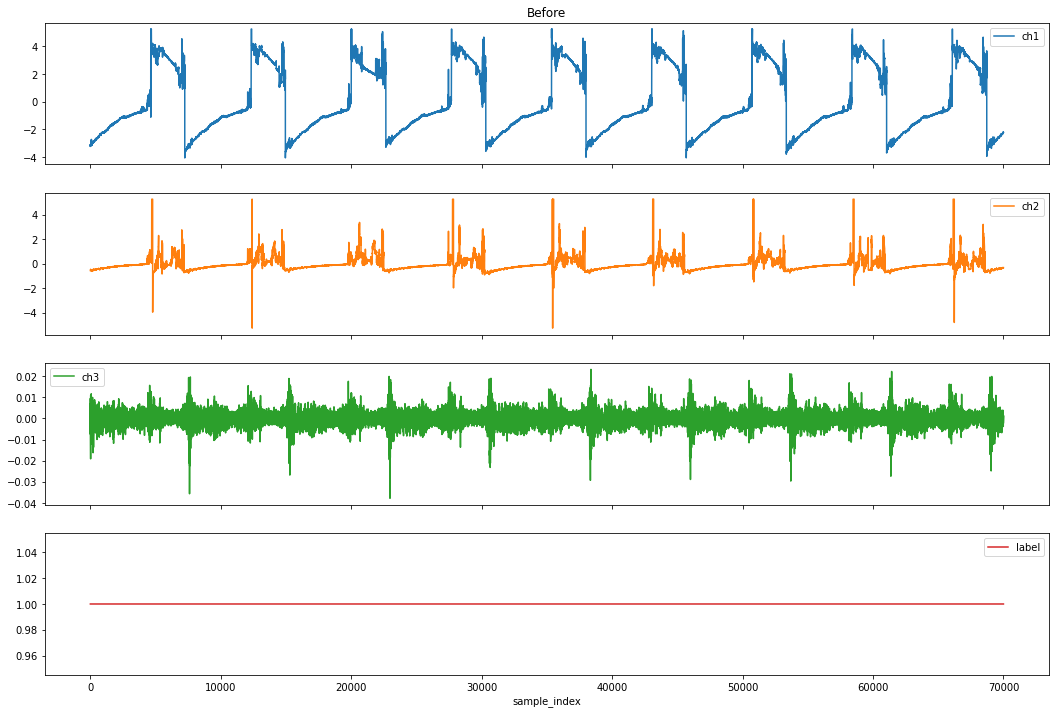

In [12]:
axs = data_p.loc[1].plot(subplots=True, figsize=(18,12))
axs[0].set_title('Before')

One may see that the first channel presents a periodic signal, similar to a retified square signal or the combination of triangular and square signal. The second channel is also periodic with peaks of amplitude that occurs in the moments of positive values of channel 1. The third channel does not seem to be periodic at first sight, also the occurrence of peaks seems not to be synchronized with any other event of the first two channels. 

Now, let's plot an after sample.

Text(0.5, 1.0, 'After')

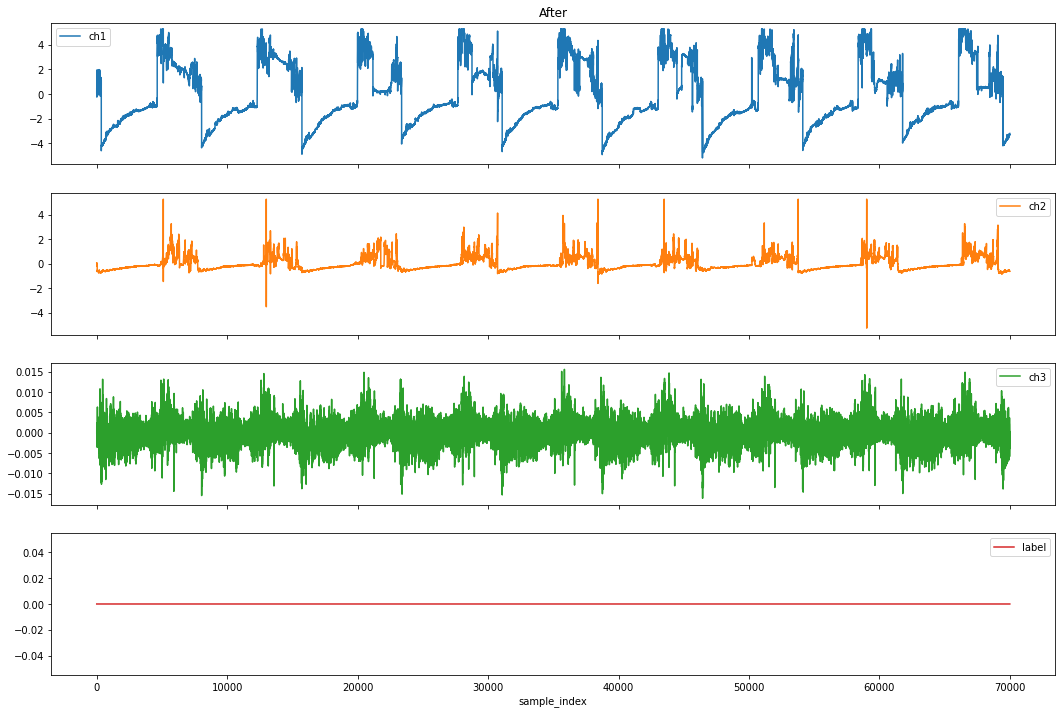

In [13]:
axs = data_p.loc[40].plot(subplots=True, figsize=(18,12))
axs[0].set_title('After')

The same observations made for the previous chart can also be made here. The only noticible difference is that the first channels seems to have a more distorced signal in the positive region, compared with the Before sample.

Now, we'll take a look in the distribution of the data. 
So we plot the histogram of the signal.

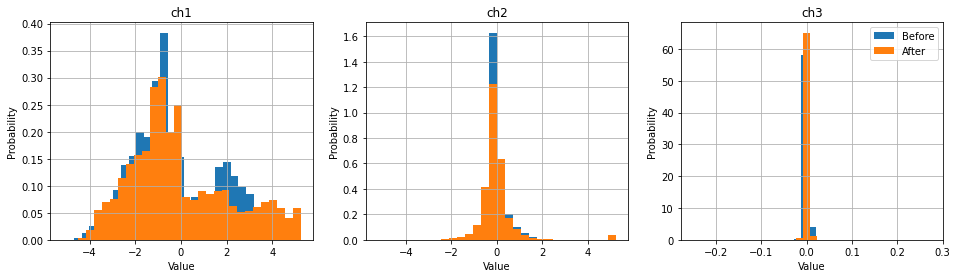

In [14]:
_, axs = plt.subplots(1,3,figsize=(16,4))

for i, col in enumerate(data.drop(columns='label',axis=1).columns):
    
    for label in ['Before', 'After']:
        axs[i].hist(data.loc[data['label']==label][col], density=True, label=label, bins=30)
    
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Probability')
    axs[i].grid()
axs[2].legend()

The only noticible difference, between the Before and After samples, is the presence of the second peak of the first channel for the Before scenario. However, since this plot shows the distribution of all samples, it is possible that this result is due to an anomaly present in one or few samples that were classified as Before. 

Now, we check for possible relations between the variables. For that, we calculate the Pearson correlation index between them and plot the scatter chart.

In [15]:
data.corr()

,ch1,ch2,ch3
ch1,1.000000,0.318531,0.181251
ch2,0.318531,1.000000,0.084202
ch3,0.181251,0.084202,1.000000


The strongest linear correlation occurs between the first two channels, however the correlation is still week (just 0.32). 

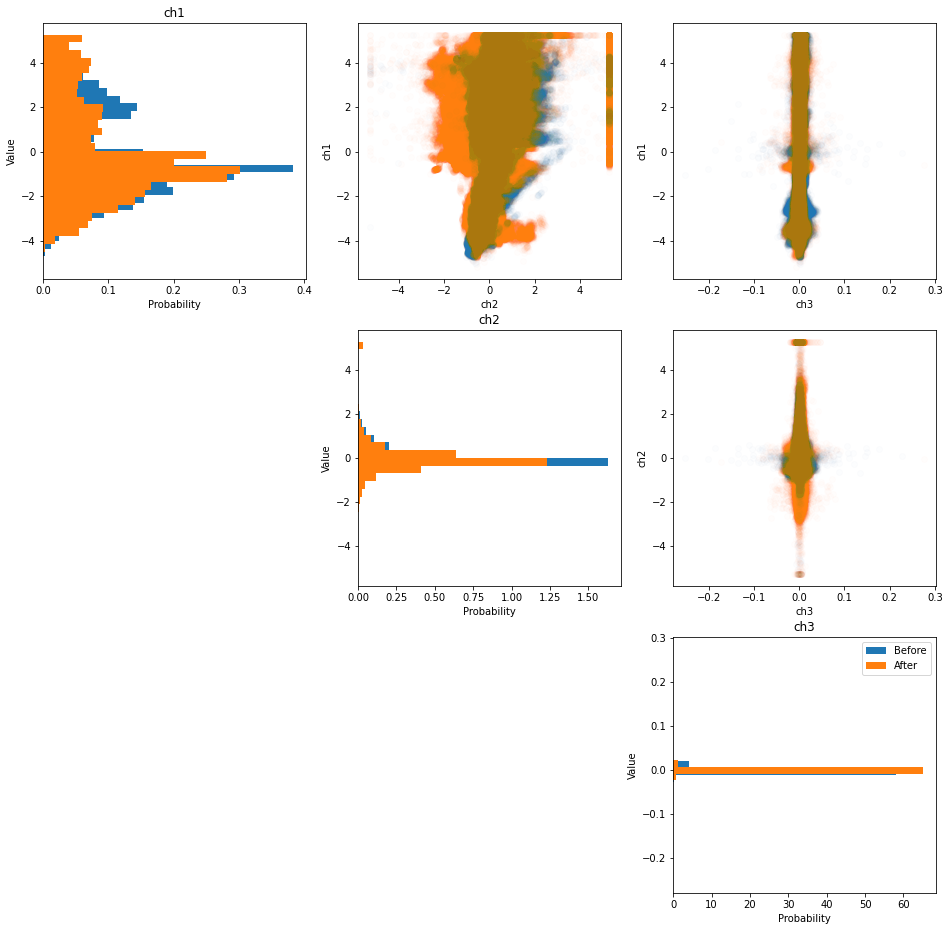

In [16]:
_, axs = plt.subplots(3,3,figsize=(16, 16))

cols_plot = data.drop(columns='label',axis=1).columns

for i, col in enumerate(cols_plot):
    
    for label in ['Before', 'After']:
        axs[i,i].hist(data.loc[data['label']==label][col], 
                      density=True, 
                      label=label, 
                      bins=30, 
                      orientation='horizontal')
    
    axs[i,i].set_title(col)
    axs[i,i].set_xlabel('Probability')
    axs[i,i].set_ylabel('Value')
    
    for j, col2 in enumerate(cols_plot[i+1:]):
        j_ = j + i + 1
        for label in ['Before', 'After']:
            axs[i,j_].scatter(y = data.loc[data['label']==label][col], 
                            x = data.loc[data['label']==label][col2], 
                            alpha = 0.01,
                            label=label)
            
    
        axs[i,j_].set_xlabel(col2)
        axs[i,j_].set_ylabel(col)
        
        axs[2-i, 2-j_].axis('off')
    
_ = axs[2,2].legend()

The charts show any apparent relation between the variables. However, as observed before, the higher dispersion of the data for the second channel occurs in the moments when channel 1 presents values close of higher than zero. Also, the scatter plot for channels 1 and 2, shows a possible way to classify the sample: value of channel 1 above -1 and value of channel 2 below -1. 
To confirm this possibility, a deeper evaluation must be made.

Now, we plot an superpositioned version of all measurements, to compare the channel 1 signal between Before and After.

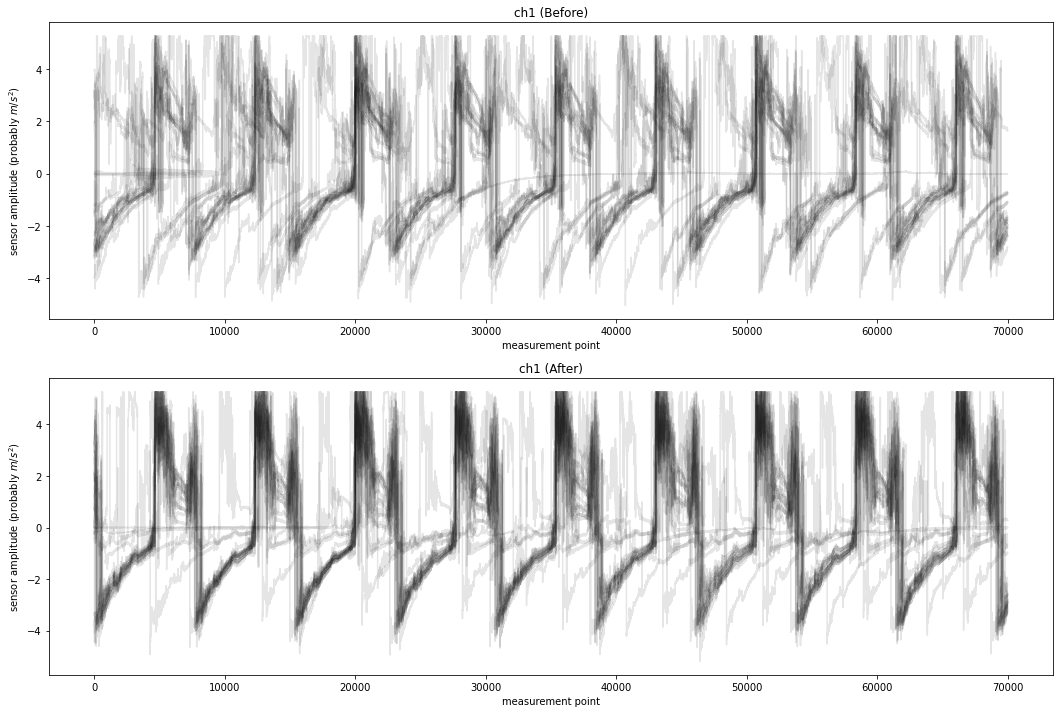

In [17]:
fig, axs = plt.subplots(2,1,figsize=(18, 12))

col_plot = 'ch1'

for i, label in enumerate(['Before', 'After']):

    data.loc[data['label']==label][[col_plot]].unstack(level=1) \
                                                .T \
                                                .unstack(level=0) \
                                                .plot(color='k', 
                                                    legend=False, 
                                                    alpha=0.1, 
                                                    ax=axs[i])
    
    axs[i].set_xlabel('measurement point')
    axs[i].set_ylabel('sensor amplitude (probably $m/s^2$)')
    axs[i].set_title('{} ({})'.format(col_plot, label))

if save_fig:
    figname = 'before_after_all_samples_ch01.png'
    fig.savefig(f"{figure_saving_folder}/{figname}", format='png')

Creating a chart for documentation

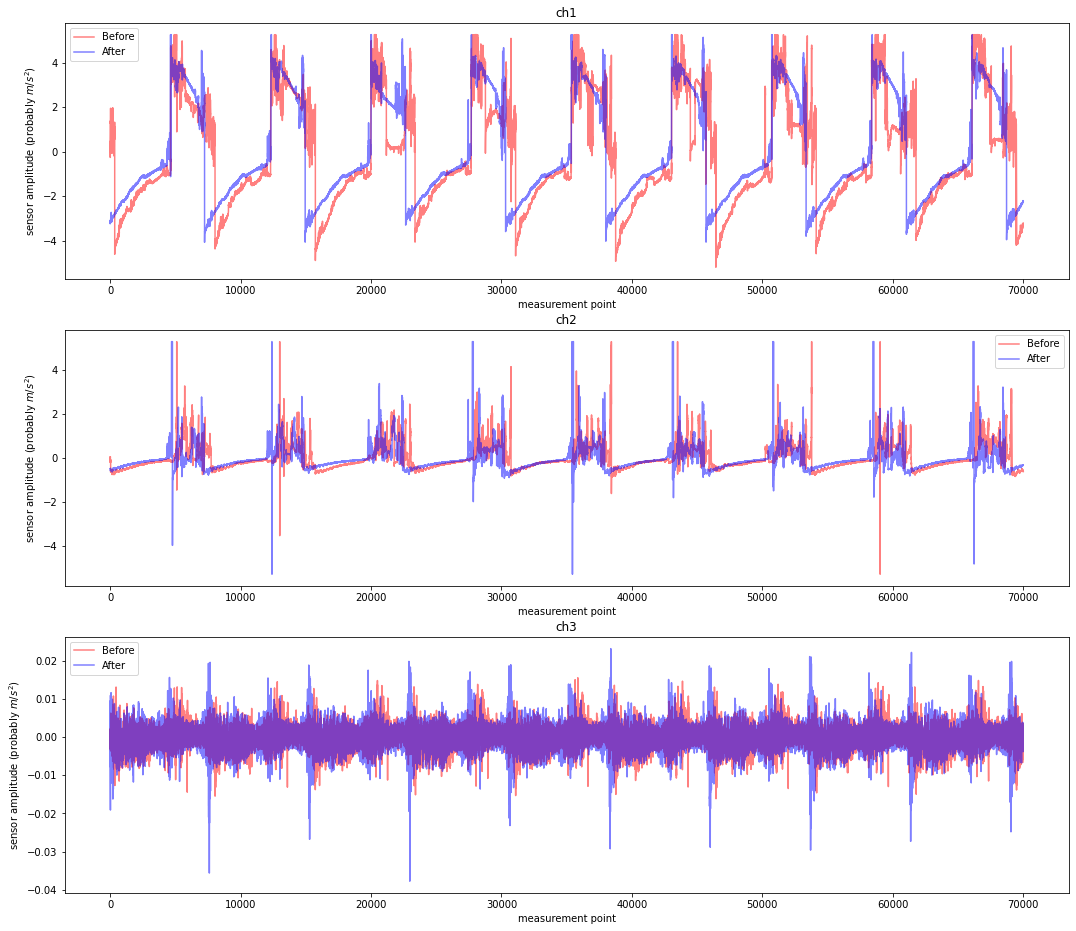

In [18]:
# Comparison of After and Before samples
fig, axs = plt.subplots(3,1,figsize=(18, 16))

col_plot = 'ch1'
colors = ['r', 'b']
sample_idx = [40, 1]

for ilabel, label in enumerate(['Before', 'After']):
    for ichannel, channel in enumerate(['ch1', 'ch2', 'ch3']):
        
        axs[ichannel].plot(data.loc[sample_idx[ilabel]][[channel]].unstack(level=1).T.values, 
                           color=colors[ilabel], 
                           alpha=0.5, 
                           label=label)
        
        axs[ichannel].set_xlabel('measurement point')
        axs[ichannel].set_ylabel('sensor amplitude (probably $m/s^2$)')
        axs[ichannel].set_title('{}'.format(channel))
        axs[ichannel].legend()
        
if save_fig:
    figname = 'before_after_samples_comparison.png'
    fig.savefig(f"{figure_saving_folder}/{figname}", format='png')

## Analysis in frequency domain

Time-Series Analysis is difficult for some reasons, among them the high dimensionality and the intrisic temporal relation. For example, is not possible to compare two samples of measurements, because the events that caracterize the studies phenomena are normally not aligned. For that reason, for feature engineering we use methods that extract the information from the signal in a different domain than time. Also, those methods reduce dimensionality. Between them we have: wavelet analysis, filtering, and methods based on Fourier Transform.

That said, let's see how is our data in the Frequency Domain. First, we'll use FFT.
However, an observation must be made here: Normally when analysing data extracted from sensors, we now what is the 
sampling frequency used when capturing the data. This is not the case here, so this information is simply ignored. The same for the measurement input unit.

In [19]:
def calc_fft(df, col, samples, N=70000):
    """Calculate the absolute value of the Fourier coeficients FFT for a list of samples"""
    
    df_ = df.copy()
    
    mat_X = np.zeros(shape=(int(N/2), len(samples)))
    
    for i, sample in enumerate(samples):
        
        x = df_.loc[sample][col].values
        mat_X[:, i] = np.abs(fft(x) * 2 / N)[:int(N/2)]
        
    return mat_X

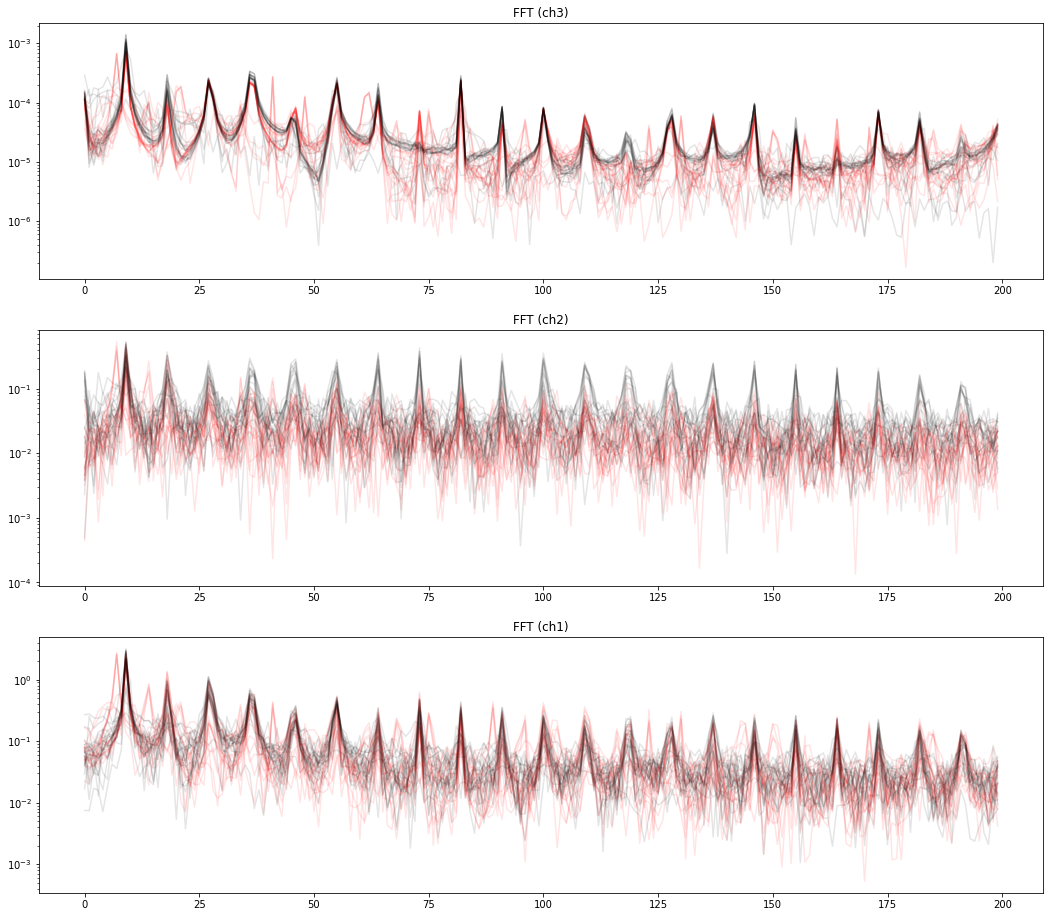

In [20]:
N_max = 200

_, axs = plt.subplots(3, 1, figsize=(18,16))

for i, col in enumerate(['ch3', 'ch2', 'ch1']):

    samples_before = data.loc[data['label'] == 'Before'].index.get_level_values(level=0).unique().tolist()
    fft_before = calc_fft(data, col, samples_before)

    samples_after = data.loc[data['label'] == 'After'].index.get_level_values(level=0).unique().tolist()
    fft_after = calc_fft(data, col, samples_after)


    _ = axs[i].semilogy(fft_before[:N_max, :], color='r', alpha=0.1)
    _ = axs[i].semilogy(fft_after[:N_max, :], color='k', alpha=0.1)
    _ = axs[i].set_title('FFT ({})'.format(col))

The chart confirms what we observed before. The data is periodic (presence of multiple peaks in the frequency domain) and the peaks between the channels seems to be aligned, what indicates the signal may be obtained by connected parts of the machine (or at least assembled together). 

Also, one may see that the Before signal is caracterized by the shift of one or more peaks in the frequency axis for some samples. This shows how the Fourier transformation was able to reduce the dimensionality of the signal, and the possibility of being used as features to classify the signal. We can then create a pd.DataFrame with those information.

In [21]:
def create_df_esp_freq(mat_X, samples, N_max, label, data_freq = None):
    """Create a pd.DataFrame with data of frequency domain."""
    
    data_freq_ = pd.DataFrame(data=mat_X[:N_max], 
                            columns=samples, 
                            index=[ 'X_{}'.format(f) for f in range(N_max)])
    
    data_freq_ = data_freq_.T
    data_freq_['label'] = label
    
    if data_freq is None:
        data_freq = data_freq_ 
        
    else:
        data_freq = pd.concat([data_freq, data_freq_], ignore_index=False)
    
    return data_freq

In [22]:
N_max = 200

data_freq = create_df_esp_freq(fft_before, samples_before, N_max, 'Before')
data_freq = create_df_esp_freq(fft_after, samples_after, N_max, 'After', data_freq)

data_freq.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_191,X_192,X_193,X_194,X_195,X_196,X_197,X_198,X_199,label
1,0.074742,0.083268,0.061022,0.078902,0.113439,0.079203,0.091540,0.182133,0.303242,2.626449,...,0.054250,0.033151,0.009288,0.017583,0.012747,0.011608,0.010259,0.025714,0.038755,Before
2,0.079661,0.069659,0.087958,0.060266,0.101453,0.089374,0.119409,0.149192,0.299828,2.578076,...,0.031155,0.021248,0.032849,0.027767,0.007877,0.017080,0.005678,0.017073,0.042830,Before
3,0.049278,0.059162,0.062487,0.053288,0.066162,0.099269,0.112314,0.175177,0.272789,2.563564,...,0.018411,0.019673,0.010798,0.009834,0.014393,0.011727,0.012682,0.019144,0.019619,Before
4,0.063572,0.061385,0.067578,0.061157,0.058538,0.056355,0.077565,0.138545,0.196699,2.000323,...,0.062075,0.048488,0.015228,0.011591,0.015477,0.017424,0.004051,0.025011,0.011183,Before
5,0.057504,0.061085,0.058764,0.047803,0.076010,0.071476,0.081635,0.119611,0.238513,1.996654,...,0.131584,0.108032,0.026935,0.011097,0.008246,0.011578,0.010411,0.024213,0.028587,Before


Creating a DF with spectrum in frequency for each channel

In [23]:
# For channel 1
fft_before_ch1 = calc_fft(data, 'ch1', samples_before)
fft_after_ch1 = calc_fft(data, 'ch1', samples_after)
data_freq_ch1 = create_df_esp_freq(fft_before_ch1, samples_before, N_max, 'Before')
data_freq_ch1 = create_df_esp_freq(fft_after_ch1, samples_after, N_max, 'After', data_freq_ch1)

# For channel 2
fft_before_ch2 = calc_fft(data, 'ch2', samples_before)
fft_after_ch2 = calc_fft(data, 'ch2', samples_after)
data_freq_ch2 = create_df_esp_freq(fft_before_ch2, samples_before, N_max, 'Before')
data_freq_ch2 = create_df_esp_freq(fft_after_ch2, samples_after, N_max, 'After', data_freq_ch2)

# For channel 3
fft_before_ch3 = calc_fft(data, 'ch3', samples_before)
fft_after_ch3 = calc_fft(data, 'ch3', samples_after)
data_freq_ch3 = create_df_esp_freq(fft_before_ch3, samples_before, N_max, 'Before')
data_freq_ch3 = create_df_esp_freq(fft_after_ch3, samples_after, N_max, 'After', data_freq_ch3)

Another way to analyse the data in other domain than time is to obtain the spectral density. Here we use the `signal.welch` function from the scipy library.

In [24]:
def calc_power_density(df, col, samples, nperseg=1024):
    """Calculate the power density a list of samples"""
    
    df_ = df.copy()
    
    mat_X = np.zeros(shape=(int(nperseg/2 + 1), len(samples)))
    
    for i, sample in enumerate(samples):
        
        x = df_.loc[sample][col].values
        _, mat_X[:, i] = signal.welch(x, average='median', scaling='spectrum', return_onesided=True, nperseg=nperseg) 
        
    return mat_X

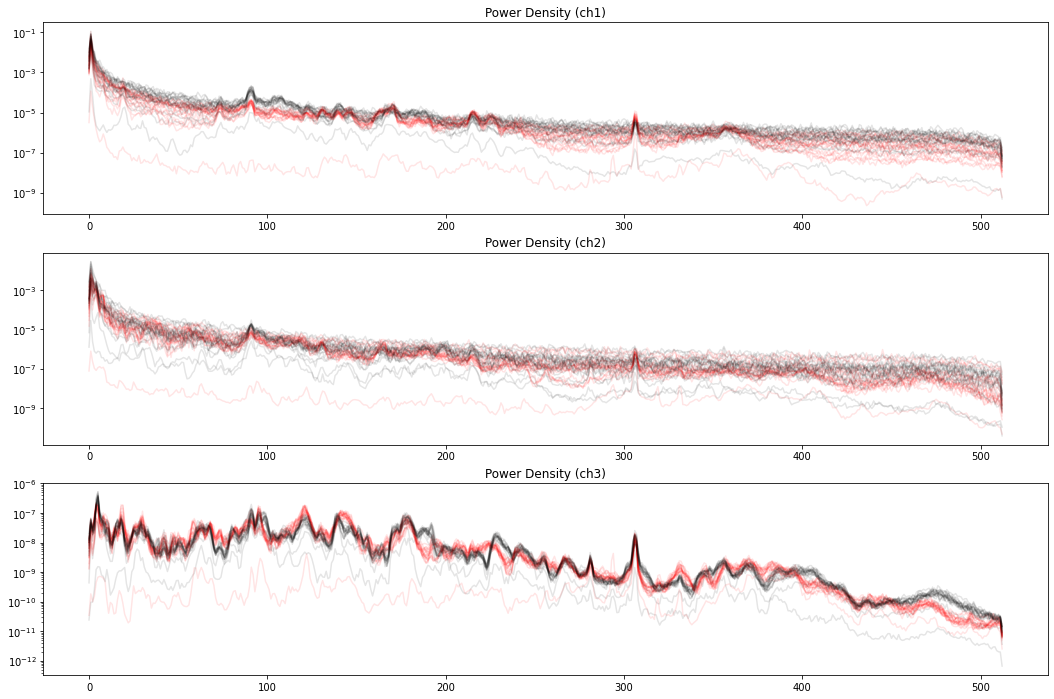

In [25]:
N_max = 200

_, axs = plt.subplots(3, 1, figsize=(18,12))

for i, col in enumerate(['ch1', 'ch2', 'ch3']):

    samples_before = data.loc[data['label'] == 'Before'].index.get_level_values(level=0).unique().tolist()
    prw_den_before = calc_power_density(data, col, samples_before, nperseg=1024)

    samples_after = data.loc[data['label'] == 'After'].index.get_level_values(level=0).unique().tolist()
    prw_den_after = calc_power_density(data, col, samples_after, nperseg=1024)


    _ = axs[i].semilogy(prw_den_before, color='r', alpha=0.1)
    _ = axs[i].semilogy(prw_den_after, color='k', alpha=0.1)
    _ = axs[i].set_title('Power Density ({})'.format(col))

Cross spectral density using Welch's method

In [26]:
def calc_cross_spec_density(df, col_x, col_y, samples, nperseg=1024):
    """Calculate the power density a list of samples"""
    
    df_ = df.copy()
    
    mat_X = np.zeros(shape=(int(nperseg/2 + 1), len(samples)))
    
    for i, sample in enumerate(samples):
        
        x = df_.loc[sample][col_x].values
        y = df_.loc[sample][col_y].values
        _, mat_X[:, i] = np.abs( signal.csd(x, y, average='median', scaling='spectrum', return_onesided=True, nperseg=nperseg) )
        
    return mat_X

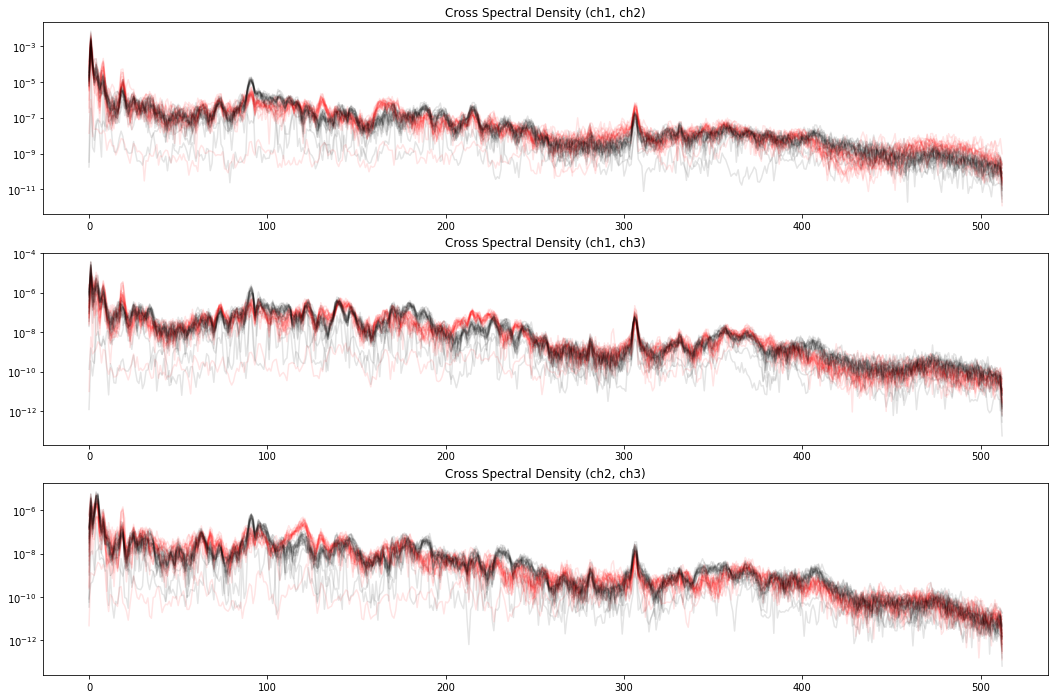

In [27]:
N_max = 200

_, axs = plt.subplots(3, 1, figsize=(18,12))

for i, cols in enumerate([['ch1', 'ch2'], ['ch1', 'ch3'], ['ch2', 'ch3']]):

    samples_before = data.loc[data['label'] == 'Before'].index.get_level_values(level=0).unique().tolist()
    prw_den_before = calc_cross_spec_density(data, cols[0], cols[1], samples_before, nperseg=1024)

    samples_after = data.loc[data['label'] == 'After'].index.get_level_values(level=0).unique().tolist()
    prw_den_after = calc_cross_spec_density(data, cols[0], cols[1], samples_after, nperseg=1024)


    _ = axs[i].semilogy(prw_den_before, color='r', alpha=0.1)
    _ = axs[i].semilogy(prw_den_after, color='k', alpha=0.1)
    _ = axs[i].set_title('Cross Spectral Density ({}, {})'.format(cols[0], cols[1]))

## Feature engineering

Now that we know better the data, let's begin with the feature engineering step. The idea here is to:
1. Reduce even more the dimensionality of the data
2. Get features with higher importance to the problem


### Peaks amplitude

For example, in the case of the Spectrum in frequency, we can get the peaks amplitude and locations as features.
So, let's do that for now.

Text(0.5, 1.0, 'Number of peaks: 30')

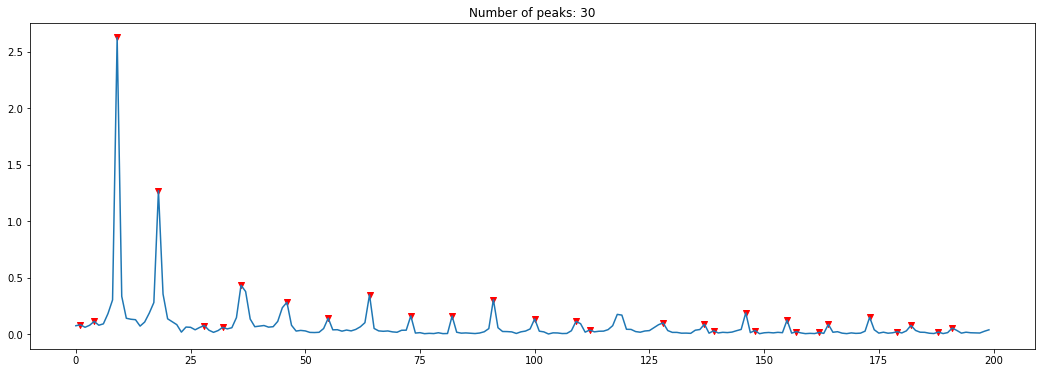

In [28]:
x = data_freq.drop(columns='label').loc[1].values
peaks_idx, _ = signal.find_peaks(x, threshold=np.quantile(x, 0.1))

_, ax = plt.subplots(figsize=(18, 6))
ax.plot(x)
ax.scatter(peaks_idx, x[peaks_idx], marker='v', color='r')
ax.set_title('Number of peaks: {}'.format(len(peaks_idx)))

In [29]:
list_peaks_idx = []
set_unique_peaks_idx = []
list_peaks_values = []

# Getting peaks indices
for i, x in data_freq.loc[data_freq.label.isin(['Before', 'After'])].drop(columns='label').iterrows():
    
    peaks_idx, _ = signal.find_peaks(x, threshold=np.quantile(x, 0.15))
    list_peaks_idx.append(peaks_idx)
    list_peaks_values.append(x[peaks_idx].values)

# Getting unique values of indices
set_peaks_idx = set()
for peaks_idx in list_peaks_idx:
    for idx in peaks_idx:
        set_peaks_idx.add(idx)
        
# Selecting only the columns related to the peaks
data_freq_peaks = data_freq.iloc[:, list(set_peaks_idx)]
data_freq_peaks = data_freq_peaks.join(data_freq.label, on=data_freq_peaks.index)
data_freq_peaks.head()  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_11,...,X_188,X_189,X_191,X_192,X_194,X_195,X_196,X_197,X_198,label
1,0.083268,0.061022,0.078902,0.113439,0.079203,0.091540,0.182133,0.303242,2.626449,0.140938,...,0.019076,0.005292,0.054250,0.033151,0.017583,0.012747,0.011608,0.010259,0.025714,Before
2,0.069659,0.087958,0.060266,0.101453,0.089374,0.119409,0.149192,0.299828,2.578076,0.130441,...,0.016746,0.013979,0.031155,0.021248,0.027767,0.007877,0.017080,0.005678,0.017073,Before
3,0.059162,0.062487,0.053288,0.066162,0.099269,0.112314,0.175177,0.272789,2.563564,0.148522,...,0.013527,0.008473,0.018411,0.019673,0.009834,0.014393,0.011727,0.012682,0.019144,Before
4,0.061385,0.067578,0.061157,0.058538,0.056355,0.077565,0.138545,0.196699,2.000323,0.113754,...,0.005465,0.002191,0.062075,0.048488,0.011591,0.015477,0.017424,0.004051,0.025011,Before
5,0.061085,0.058764,0.047803,0.076010,0.071476,0.081635,0.119611,0.238513,1.996654,0.132128,...,0.024439,0.041525,0.131584,0.108032,0.011097,0.008246,0.011578,0.010411,0.024213,Before


To estimate how well the model can perform using the selected columns, let's reduce the dimension of the 
dataframe using PCA and plot.

In [30]:
from sklearn.decomposition import PCA

Explained variance:  0.7816159724273375


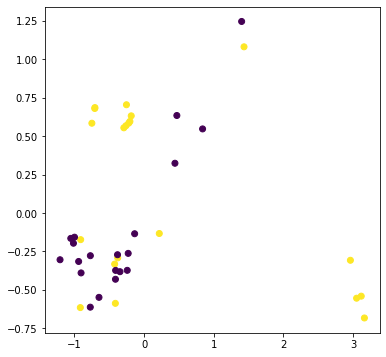

In [31]:
X = data_freq_peaks.drop(columns='label').values
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(figsize=(6,6))
ax.scatter(x = X_pca[:,0], y=X_pca[:,1], c=[1 if label == 'Before' else 0 for label in data_freq_peaks.label])

It's clear that a some of information was lost with the process, however is interesting to see that for some set of samples from the same label formed small groups. That may be positive sign for that set of features.

Now, let's get just the peaks position (in the frequency vector).

### Peaks position

In [32]:
def get_peaks_pos(df, n_max_positions=3):
    
    df_ = df.drop(columns='label').copy()
    N_samples = len(df_.columns)
    
    array_peaks_pos = np.zeros(shape=(len(df_), n_max_positions))

    for i, row in df_.iterrows():
        row_ = row.copy()
        for pos in range(1, n_max_positions+1):
            idx_max = row_.argmax() 
            position = int(row_.index[idx_max].split('_')[-1])
            row_ = row_.drop(index = row_.index[idx_max])

            array_peaks_pos[i-1, pos-1] = position / N_samples

    data_peak_pos = pd.DataFrame(data=array_peaks_pos, 
                                 columns = ['freqmax_{}'.format(i) for i in range(1, n_max_positions+1)], 
                                 index = df_.index)

    return data_peak_pos

In [33]:
data_peak_pos = get_peaks_pos(data_freq, n_max_positions=5)
data_peak_pos.head()

,freqmax_1,freqmax_2,freqmax_3,freqmax_4,freqmax_5
1,0.045,0.09,0.18,0.185,0.095
2,0.045,0.09,0.18,0.095,0.050
3,0.045,0.09,0.18,0.095,0.185
4,0.045,0.09,0.41,0.185,0.180
5,0.045,0.09,0.18,0.185,0.050


Let's check how well this can work as features.

Explained variance:  0.7572534632200985


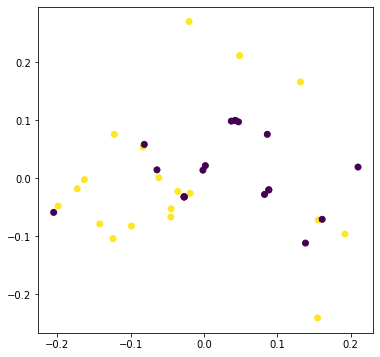

In [34]:
X = data_peak_pos.values
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(figsize=(6,6))
ax.scatter(x = X_pca[:,0], y=X_pca[:,1], c=[1 if label == 'Before' else 0 for label in data_freq.label])



It seems that would be possible to get a bondary that separates the classes. However we notice that quite some information is lost with the PCA. Now, let's see how would it be, if we combine both features.

Explained variance:  0.877480981630747


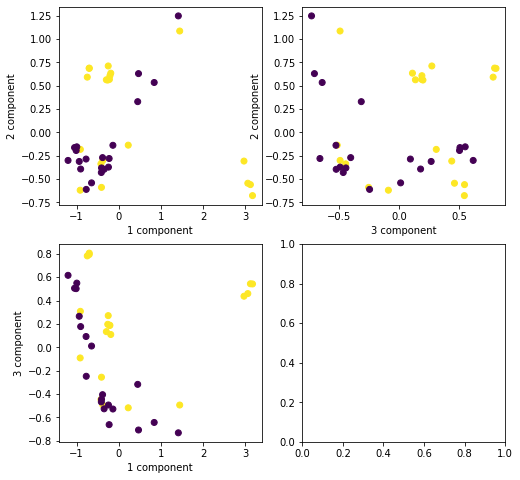

In [35]:
X = pd.concat([data_freq_peaks, data_peak_pos], axis=1, ignore_index=False).drop(columns='label').values
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(2,2, figsize=(8,8))

for (i,j), (xi, yi) in zip([(0,0), (0,1), (1,0)], [(0,1), (2,1), (0,2)]):
    ax[i,j].scatter(x = X_pca[:,xi], y=X_pca[:,yi], c=[1 if label == 'Before' else 0 for label in data_freq.label])
    ax[i,j].set(xlabel='{} component'.format(xi+1), ylabel='{} component'.format(yi+1))

It is noticible that the columns related to the peaks position turned to have a higher impact on the transformed data (the chart above is practically the same from the transformed data using only the peaks position). That fact is due to lack of a scaling preprocess step. So, let's check would be if we scale the data. 

In [36]:
def minmax_scale_matrix(df):
    
    df_ = df.copy()
    if 'label' in df.columns:
        df_ = df_.drop(columns='label')
        
    x_min = df_.values.min()
    x_max = df_.values.max()
    
    df_ = (df_ - x_min) / (x_max - x_min)
    
    if 'label' in df.columns:
        df_ = df_.join(df[['label']])
    
    return df_

def std_scale_data_matrix(df):
    
    df_ = df.drop(columns='label').copy()
    x_mean = df_.mean(axis=1).mean()
    x_std = df_.std(axis=1).mean()    
    df_ = (df_ - x_mean) / x_std
    
    df_ = df_.join(df[['label']])
    
    return df_

def log_std_scale_data_freq_peaks(df):
        
    df_ = df.drop(columns='label').copy()
    x_log = np.log(df_)
    x_log_mean = x_log.mean(axis=1).mean()
    x_log_std = x_log.std(axis=1).mean()
    
    df_ = (x_log - x_log_mean) / x_log_std
    df_ = df_.join(df[['label']])
    
    return df_


def log_minmax_scale_data_freq_peaks(df):
        
    df_ = df.drop(columns='label').copy()
    x_log = np.log(df_)
    x_log_min = x_log.values.min()
    x_log_max = x_log.values.max()
    
    df_ = (x_log - x_log_min) / (x_log_max - x_log_min)
    df_ = df_.join(df[['label']])
    
    return df_

data_freq_peaks_scaled = log_minmax_scale_data_freq_peaks(data_freq_peaks)

Due to the distribution of the original data (plot histogram of one spectrum in frequency to see), the Minimum-Maximum and Standard scalers doesn't transform the data appropriately (the transformed data continues to be highly skewed).
For that reason, we use the last function `log_minmax_scale_data_freq_peaks`.

<AxesSubplot:>

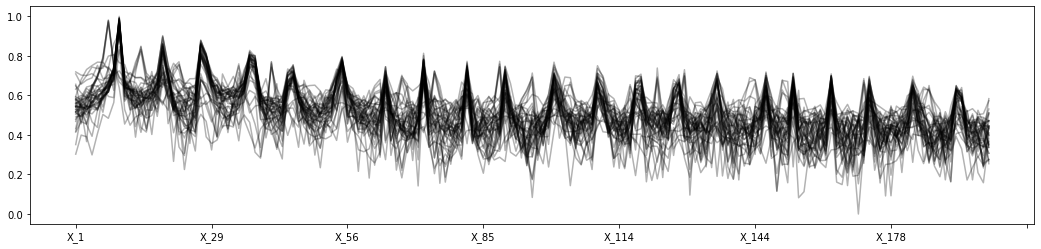

In [37]:
data_freq_peaks_scaled.drop(columns='label').T.plot(legend=False, color='k', alpha=0.3, figsize=(18,4))

In [38]:
data_peak_pos_scaled = minmax_scale_matrix(data_peak_pos)

Explained variance:  0.4416546733603341


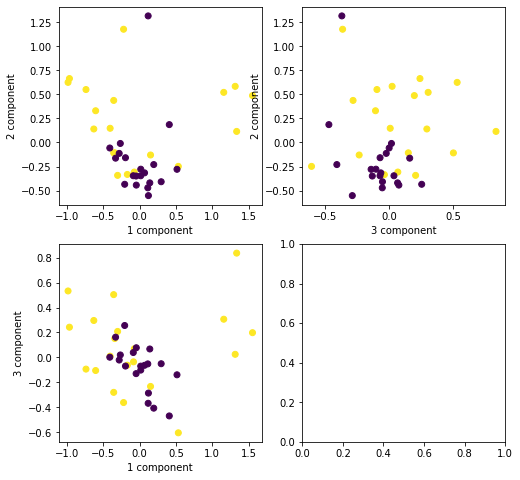

In [39]:
X = pd.concat([data_freq_peaks_scaled, data_peak_pos_scaled], axis=1, ignore_index=False).drop(columns='label').values
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(2,2, figsize=(8,8))

for (i,j), (xi, yi) in zip([(0,0), (0,1), (1,0)], [(0,1), (2,1), (0,2)]):
    ax[i,j].scatter(x = X_pca[:,xi], y=X_pca[:,yi], c=[1 if label == 'Before' else 0 for label in data_freq.label])
    ax[i,j].set(xlabel='{} component'.format(xi+1), ylabel='{} component'.format(yi+1))

The results shows that much information were lost with the transformation (only 44% of the explained variance is kept). However the charts show that maybe possible to separate the classes with a boundary condition. 

Now, let's start working with features usually used in signal processing.

### Total Harmonic Distortion 

[Wikipedia article on Total Harmonic Distortion](https://en.wikipedia.org/wiki/Total_harmonic_distortion).

In a simpler explanation, THD is the area of the peaks without consider a range of frequencies around the hamonic frequency - that is, the energy of only the noise.
See example below.

In [40]:
from numpy.fft import rfft, irfft

In [41]:
def parabolic(f, x):
    """
    Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    f is a vector and x is an index for that vector.
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    if int(x) != x:
        raise ValueError('x must be an integer sample index')
    else:
        x = int(x)
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

An example...

RMS real signal:  89.59329184362451 
RMS of the noise signal:  87.66453797181477


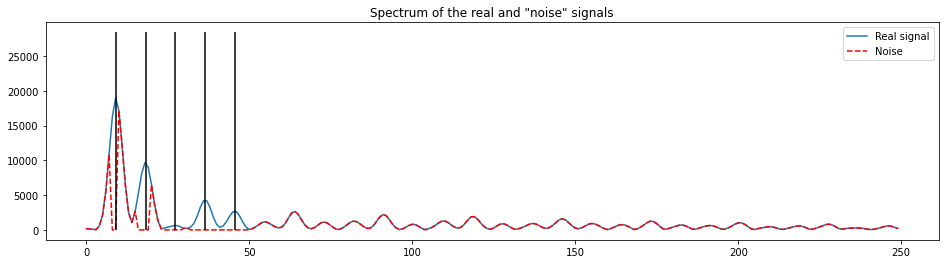

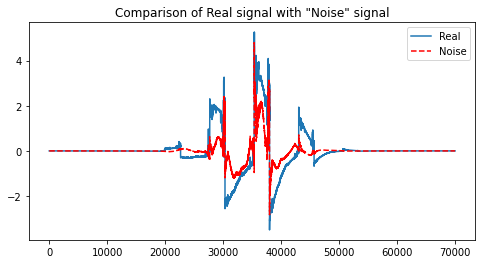

In [42]:
def plot_example_thd(n_sample, N_plot, f_max=250, channel='ch1'):

    x = data.loc[n_sample][channel].values
    # Filtering the data
    window = signal.windows.kaiser(M=70000, beta=38)
    windowed =  window * x
    # Obtaining the Spectrum in frequency
    f = rfft(windowed)
    # Getting the harmonic frequency
    i = np.argmax(np.abs(f[:f_max]))
    max_X = np.abs(f[i])
    true_i = parabolic(np.log(np.abs(f)), i)[0]

    # Real RMS (with the noise)
    rms_total = 20*np.log10(np.sqrt(np.abs(f.T @ f)))

    plt.figure(figsize=(16,4))
    plt.plot(np.abs(f[:N_plot]), label='Real signal')

    # Removing the region around harmonic frequencies
    n_harm = 5
    fund_wind_ratio = 0.1
    for nn in range(1, n_harm + 1):

        lowermin = int(true_i * nn * (1 - fund_wind_ratio))
        uppermin = int(true_i * nn * (1 + fund_wind_ratio))

        f[lowermin : uppermin] = 0

    # Simulating a signal using only the spectrum of the "noise"
    noise = window * irfft(f)

    # RMS of the noised signal
    rms_noise = 20*np.log10(np.sqrt(np.abs(f.T @ f)))

    plt.plot(np.abs(f[:N_plot]), 'r--', label='Noise')
    plt.title('Spectrum of the real and "noise" signals')
    plt.legend()

    for ii in range(1, 6):
        plt.vlines(true_i * ii, 0, 1.5 * max_X, 'k', label = 'After removing harmonic')

    print('RMS real signal: ', rms_total, '\nRMS of the noise signal: ', rms_noise)

    plt.figure(figsize=(8,4))
    plt.plot(windowed, '-', label='Real')
    plt.plot(noise, 'r--', label='Noise')
    plt.title('Comparison of Real signal with "Noise" signal')
    plt.legend()
    
    
n_sample = 1
N_plot = 250
plot_example_thd(n_sample, N_plot, f_max=250,channel='ch1')

In [43]:
def calculate_tdhn(df, col, samples, N=70000, beta_filter=38, n_harm=5, wind_fund_ratio=0.1, f_max=250):
    
    df_ = df.loc[samples][col].unstack().copy()
    
    mat_X = np.zeros(shape=(int(N/2 + 1), len(samples))) # Row: frequency, column: sample
    mat_X_noise = mat_X.copy()
    
    f_fund = []
    rms_total = []
    rms_noise = []
    
    # Defining and window
    window = signal.windows.kaiser(M=N, beta=beta_filter) 
    windowed = (df_.values * window).T  # Row: Time, column: Sample 

    for i, sample in enumerate(samples):
        
        x = windowed[:, i]
        X = rfft(x)
        mat_X[:, i] =  np.abs(X)
        
        fund_f_idx = np.argmax(np.abs(X[:f_max]))
        true_f_idx = parabolic(np.log(np.abs(X)), fund_f_idx)[0]
        f_fund.append(true_f_idx)
        
        rms_total.append(20*np.log10(np.sqrt(np.abs(X.T @ X))))
        
        # Setting fundamental and harmonic regions to zero
        for nn in range(1, n_harm + 1):

            lowermin = int(true_f_idx * nn * (1 - wind_fund_ratio))
            uppermin = int(true_f_idx * nn * (1 + wind_fund_ratio))

            X[lowermin : uppermin] = 0.0
        
        mat_X_noise[:, i] = np.abs(X)
        
        rms_noise.append(20*np.log10(np.sqrt(np.abs(X.T @ X))))
        
    return f_fund, rms_total, rms_noise

In [44]:
col = 'ch1'

def get_tdhn_by_channel(df, channel='ch1'):
    df_ = df.copy()
    samples_before = df_.loc[data['label'] == 'Before'].index.get_level_values(level=0).unique().tolist()
    f_fund_before, rms_total_before, rms_noise_before = calculate_tdhn(df_, channel, samples_before)

    samples_after = df_.loc[data['label'] == 'After'].index.get_level_values(level=0).unique().tolist()
    f_fund_after, rms_total_after, rms_noise_after = calculate_tdhn(df_, channel, samples_after)

    # Creating a DF with the results
    df_tdhn = pd.DataFrame(index=samples_before, 
                           data={'f_fund': f_fund_before, 
                                 'rms_total' : rms_total_before,
                                'rms_noise': rms_noise_before,
                                'label': [1]*len(samples_before)})

    df_tdhn_ = pd.DataFrame(index=samples_after, 
                           data={'f_fund': f_fund_after, 
                                'rms_total' : rms_total_after,
                                'rms_noise': rms_noise_after,
                                'label': [0]*len(samples_after)})

    df_tdhn = pd.concat([df_tdhn, df_tdhn_], axis=0, ignore_index=False)
    df_tdhn['rms_ratio'] = df_tdhn['rms_noise'] / df_tdhn['rms_total']

    return df_tdhn
    
df_tdhn = get_tdhn_by_channel(data) 
df_tdhn.head()

,f_fund,rms_total,rms_noise,label,rms_ratio
1,9.110484,89.593292,87.664538,1,0.978472
2,9.154383,89.336934,87.510842,1,0.979559
3,9.103135,89.258598,87.443924,1,0.979669
4,9.094853,87.959808,85.855597,1,0.976078
5,9.117378,87.157370,85.079891,1,0.976164


<AxesSubplot:xlabel='f_fund', ylabel='rms_ratio'>

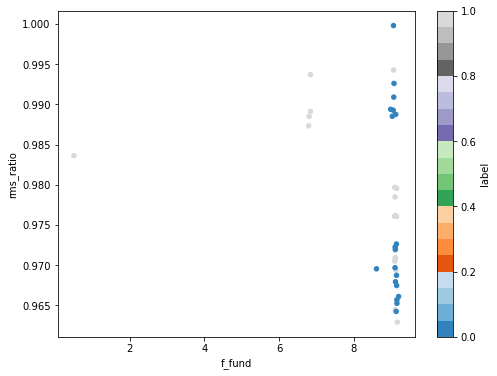

In [45]:
_, ax = plt.subplots(figsize=(8, 6))
df_tdhn.drop(index=[11,14,21]).plot(
            kind='scatter', 
             x = 'f_fund', 
             y = 'rms_ratio', 
             c = 'label', 
             cmap='tab20c',
             ax=ax
            )

We see that for the cases where the fundamental frequency is below 9, the samples is from the "Before" set. Our effort will be to different the cases where the frequency is equal to the After label.

Let's see how the data is when combined to the previous features.
First with the peaks values.

In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
data_freq_peaks_scaled = log_minmax_scale_data_freq_peaks(data_freq_peaks)
data_tdhn = get_tdhn_by_channel(data, channel='ch1').drop(columns=['rms_total', 'rms_noise', 'label']) 

data_tdhn_scaled = data_tdhn.apply(lambda x: (x - x.min())/ (x.max() - x.min()))
data_tdhn_scaled.head()

,f_fund,rms_ratio
1,0.988928,0.432309
2,0.993969,0.461255
3,0.988083,0.464183
4,0.987132,0.368565
5,0.989719,0.370867


Explained variance:  0.45965175247181006


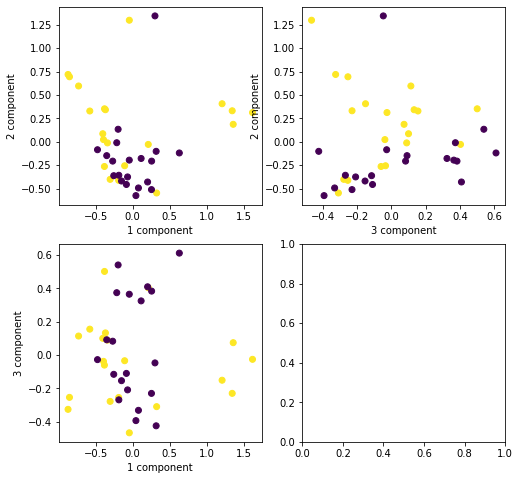

In [48]:
X = pd.concat([data_freq_peaks_scaled, data_tdhn_scaled], axis=1, ignore_index=False).drop(columns='label').values
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(2,2, figsize=(8,8))

for (i,j), (xi, yi) in zip([(0,0), (0,1), (1,0)], [(0,1), (2,1), (0,2)]):
    ax[i,j].scatter(x = X_pca[:,xi], y=X_pca[:,yi], c=[1 if label == 'Before' else 0 for label in data_freq.label])
    ax[i,j].set(xlabel='{} component'.format(xi+1), ylabel='{} component'.format(yi+1))

The explained variance obtained by the transformed data is considerably low for any conclusions. 

Let's see how would be combining only with the positions of the peaks.

In [49]:
data_peak_pos_scaled = minmax_scale_matrix(data_peak_pos)
data_tdhn = get_tdhn_by_channel(data, channel='ch1').drop(columns=['rms_total', 'rms_noise']) 
data_tdhn_scaled = data_tdhn.apply(lambda x: (x - x.min())/ (x.max() - x.min()))

Explained variance:  0.8166525958707102


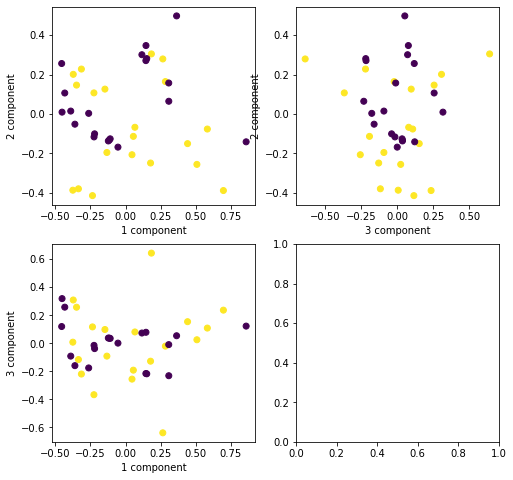

In [50]:
X = pd.concat([data_peak_pos_scaled, data_tdhn_scaled], axis=1, ignore_index=False).drop(columns='label').values
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(2,2, figsize=(8,8))

for (i,j), (xi, yi) in zip([(0,0), (0,1), (1,0)], [(0,1), (2,1), (0,2)]):
    ax[i,j].scatter(x = X_pca[:,xi], y=X_pca[:,yi], c=[1 if label == 'Before' else 0 for label in data_freq.label])
    ax[i,j].set(xlabel='{} component'.format(xi+1), ylabel='{} component'.format(yi+1))

And finally, combining all the three set of features.

In [51]:
data_tdhn = get_tdhn_by_channel(data, channel='ch1').drop(columns=['rms_total', 'rms_noise', 'label']) 
data_tdhn_scaled = data_tdhn.apply(lambda x: (x - x.min())/ (x.max() - x.min()))

Explained variance:  0.4435122860467185


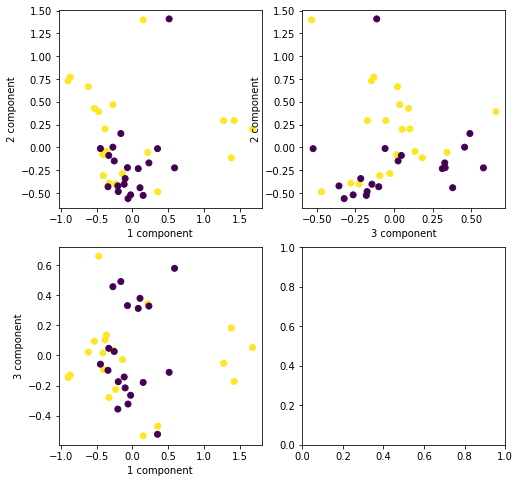

In [52]:
X = pd.concat([data_freq_peaks_scaled,data_peak_pos_scaled, data_tdhn_scaled], axis=1, ignore_index=False)\
    .drop(columns='label').values
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

print('Explained variance: ', pca.explained_variance_ratio_.sum())

_, ax = plt.subplots(2,2, figsize=(8,8))

for (i,j), (xi, yi) in zip([(0,0), (0,1), (1,0)], [(0,1), (2,1), (0,2)]):
    ax[i,j].scatter(x = X_pca[:,xi], y=X_pca[:,yi], c=[1 if label == 'Before' else 0 for label in data_freq.label])
    ax[i,j].set(xlabel='{} component'.format(xi+1), ylabel='{} component'.format(yi+1))

The combination of spectrum frequency and total distortion results are predominant in the results of the transformation (compare with chart obtained with the two).

### Basic and Higher order statistics

Finally, the features that all studies on time-series analysis must have: the ones based on statistics.  
So, let's calculate those on the data in the time domain.

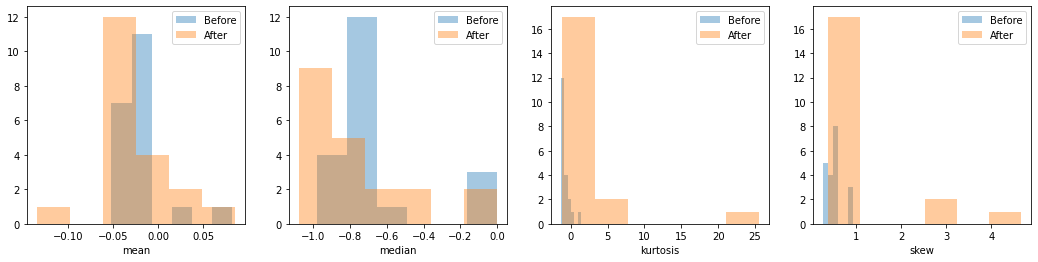

In [53]:
df_stats_summary = data['ch1'].unstack().agg(['mean', 'median', 'kurtosis', 'skew'], axis=1)
df_stats_summary['label'] = labels.values

_, axs = plt.subplots(1, 4, figsize=(18,4))

for i, col in enumerate(df_stats_summary.drop('label',axis=1).columns):
    for lab in ['Before', 'After']:
        axs[i].hist(x=df_stats_summary[df_stats_summary['label'] == lab][col], 
                    label=lab, 
                    alpha=0.4, 
                    bins=int(np.sqrt(40)))
        
        axs[i].legend()
        axs[i].set_xlabel(col)

The higher order statistics parameters present a different distribution, where for the "Before" class the values are concentrated the range near zero. For the "After" class, the values varies up to 25 for Kurtosis and to 4 for Skewness. This can be confirmed by the box plot below.

kurtosis       AxesSubplot(0.125,0.125;0.352273x0.755)
skew        AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

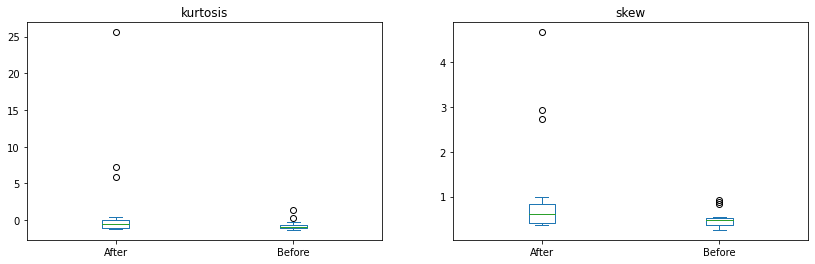

In [54]:
df_stats_summary[['kurtosis','skew', 'label']].plot.box(by='label', figsize=(14,4))

# Feature selection 

Given all features we considered until here, now it's time to filter the ones that may not contribute with our objective. 
For that, let's consider the sklearn class `SelectKBest`.

In [55]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

Calculating tdhn for all channels.

In [56]:
list_df = []
for col in ['ch1', 'ch2', 'ch3']:
    
    samples_before = data.loc[data['label'] == 'Before'].index.get_level_values(level=0).unique().tolist()
    f_fund_before, rms_total_before, rms_noise_before = calculate_tdhn(data, col, samples_before)

    samples_after = data.loc[data['label'] == 'After'].index.get_level_values(level=0).unique().tolist()
    f_fund_after, rms_total_after, rms_noise_after = calculate_tdhn(data, col, samples_after)

    # Creating a DF with the results
    df_tdhn_before = pd.DataFrame(index=samples_before, 
                           data={col + '_f_fund': f_fund_before, 
                                 col + '_rms_total' : rms_total_before,
                                col + '_rms_noise': rms_noise_before,
                                col + '_rms_ratio': [rms_noise_before[i] / rms_total_before[i] 
                                                     for i in range(len(samples_before))]})
    
    df_tdhn_after = pd.DataFrame(index=samples_after, 
                           data={col + '_f_fund': f_fund_after, 
                                col + '_rms_total' : rms_total_after,
                                col + '_rms_noise': rms_noise_after,
                                col + '_rms_ratio': [rms_noise_after[i] / rms_total_after[i] 
                                                     for i in range(len(samples_after))]})
    
    list_df.append(pd.concat([df_tdhn_before, df_tdhn_after], axis=0, ignore_index=False))
    


df_tdhn = pd.concat(list_df, axis=1, ignore_index=False)
df_tdhn.head()

,ch1_f_fund,ch1_rms_total,ch1_rms_noise,ch1_rms_ratio,ch2_f_fund,ch2_rms_total,ch2_rms_noise,ch2_rms_ratio,ch3_f_fund,ch3_rms_total,ch3_rms_noise,ch3_rms_ratio
1,9.110484,89.593292,87.664538,0.978472,9.088252,74.305626,73.823216,0.993508,9.123739,23.102756,22.759425,0.985139
2,9.154383,89.336934,87.510842,0.979559,9.133319,71.562489,69.481246,0.970917,9.106262,21.332678,21.482302,1.007014
3,9.103135,89.258598,87.443924,0.979669,9.120729,73.130610,70.861794,0.968976,9.104318,19.287373,19.756524,1.024324
4,9.094853,87.959808,85.855597,0.976078,9.040343,70.712086,70.082638,0.991098,9.104549,23.254858,24.120525,1.037225
5,9.117378,87.157370,85.079891,0.976164,8.763813,68.739847,66.934123,0.973731,9.114941,22.605772,21.520545,0.951993


Calculating the statistical summary table for all channels.

In [57]:
list_dfs = []
for col in ['ch1', 'ch2', 'ch3']:
    df_stats_summary_ = data[col].unstack().agg(['mean', 'median', 'kurtosis', 'skew'], axis=1)
    
    rename = {name: col + '_' + name for name in df_stats_summary_.columns}
    list_dfs.append(df_stats_summary_.rename(columns=rename))
    
df_stats_summary = pd.concat(list_dfs, axis=1, ignore_index=False)
df_stats_summary['label'] = labels.values
df_stats_summary.head()

,ch1_mean,ch1_median,ch1_kurtosis,ch1_skew,ch2_mean,ch2_median,ch2_kurtosis,ch2_skew,ch3_mean,ch3_median,ch3_kurtosis,ch3_skew,label
sample,,,,,,,,,,,,,
1,-0.037371,-0.847030,-1.191305,0.487839,-0.032332,-0.151054,31.568290,4.523122,-0.000054,0.000002,5.661682,-0.267440,Before
2,-0.039830,-0.845908,-1.162102,0.495646,-0.033310,-0.107796,46.163683,5.548146,-0.000049,0.000010,5.787246,-0.217547,Before
3,-0.024639,-0.809040,-1.137395,0.531198,-0.012052,-0.125662,39.253902,4.363865,-0.000063,-0.000008,4.938717,-0.215155,Before
4,-0.031786,-0.683243,-0.801407,0.512377,-0.005049,-0.083425,8.010776,2.332447,-0.000060,-0.000010,14.041460,-0.230395,Before
5,-0.028752,-0.662667,-0.939933,0.479408,-0.001899,-0.072295,5.529631,1.766123,-0.000075,-0.000029,12.223418,-0.234708,Before


In [58]:
df_stats_summary_scaled = df_stats_summary.select_dtypes(float).apply(lambda x: (x - x.min()) / (x.max() - x.min()))\
                        .join(df_stats_summary[['label']])

Creating a df with Spectrum in frequency for all channels

In [59]:
def get_peaks_values(df, considered_labels=['Before', 'After']):
    list_peaks_idx = []
    set_unique_peaks_idx = []
    list_peaks_values = []

    # Getting peaks indices
    for i, x in df.loc[df.label.isin(considered_labels)].drop(columns='label').iterrows():

        peaks_idx, _ = signal.find_peaks(x, threshold=np.quantile(x, 0.15))
        list_peaks_idx.append(peaks_idx)
        list_peaks_values.append(x[peaks_idx].values)

    # Getting unique values of indices
    set_peaks_idx = set()
    for peaks_idx in list_peaks_idx:
        for idx in peaks_idx:
            set_peaks_idx.add(idx)

    # Selecting only the columns related to the peaks
    data_freq_peaks = df.iloc[:, list(set_peaks_idx)]
    data_freq_peaks = data_freq_peaks.join(df.label, on=data_freq_peaks.index)
    
    return data_freq_peaks

In [60]:
def get_peaks_pos(df, n_max_positions=3):
    
    df_ = df.drop(columns='label').copy()
    N_samples = len(df_.columns)
    
    array_peaks_pos = np.zeros(shape=(len(df_), n_max_positions))

    for i, row in df_.iterrows():
        row_ = row.copy()
        for pos in range(1, n_max_positions+1):
            idx_max = row_.argmax() 
            position = int(row_.index[idx_max].split('_')[-1])
            row_ = row_.drop(index = row_.index[idx_max])

            array_peaks_pos[i-1, pos-1] = position / N_samples

    data_peak_pos = pd.DataFrame(data=array_peaks_pos, 
                                 columns = ['freqmax_{}'.format(i) for i in range(1, n_max_positions+1)], 
                                 index = df_.index)

    return data_peak_pos

In [61]:
# Checking for the original dfs
isinstance(data_freq_ch1, pd.DataFrame)
isinstance(data_freq_ch2, pd.DataFrame)
isinstance(data_freq_ch3, pd.DataFrame)

# Combining the dfs (scaled versions)
def rename_df_channel(df, channel):
    rename_cols = {col: '{}_{}'.format(channel, col) for col in df.drop(columns=set(['label'])&set(df.columns)).columns}
    df = df.rename(columns=rename_cols)
    return df

data_freq_scaled = pd.concat([
                log_minmax_scale_data_freq_peaks(get_peaks_values(rename_df_channel(data_freq_ch1, 'ch1'))).drop(columns='label'),
                log_minmax_scale_data_freq_peaks(get_peaks_values(rename_df_channel(data_freq_ch2, 'ch2'))).drop(columns='label'),
                log_minmax_scale_data_freq_peaks(get_peaks_values(rename_df_channel(data_freq_ch3, 'ch3')))
            ], axis=1, ignore_index=False)

data_freq_scaled.head()

,ch1_X_1,ch1_X_2,ch1_X_3,ch1_X_4,ch1_X_5,ch1_X_6,ch1_X_7,ch1_X_8,ch1_X_9,ch1_X_11,...,ch3_X_171,ch3_X_173,ch3_X_178,ch3_X_182,ch3_X_185,ch3_X_191,ch3_X_192,ch3_X_196,ch3_X_198,label
1,0.580713,0.544959,0.574517,0.616278,0.574955,0.591607,0.670739,0.729379,0.977702,0.641245,...,0.424660,0.640900,0.429344,0.603692,0.385995,0.390861,0.516129,0.520419,0.561100,Before
2,0.560187,0.587015,0.543526,0.603433,0.588852,0.622178,0.647791,0.728076,0.975564,0.632342,...,0.391572,0.641154,0.451792,0.600208,0.403883,0.374573,0.520307,0.519964,0.564451,Before
3,0.541399,0.547689,0.529372,0.554261,0.600930,0.615132,0.666261,0.717205,0.974915,0.647274,...,0.401755,0.637347,0.464388,0.596218,0.413159,0.290087,0.527687,0.522669,0.572801,Before
4,0.545642,0.556697,0.545214,0.540178,0.535808,0.572552,0.639275,0.679589,0.946378,0.616597,...,0.355526,0.660140,0.365231,0.596965,0.390909,0.164228,0.241843,0.385469,0.493852,Before
5,0.545077,0.540623,0.516877,0.570222,0.563147,0.578434,0.622372,0.701761,0.946167,0.633820,...,0.491813,0.664783,0.405784,0.614907,0.394864,0.445413,0.437565,0.495695,0.576276,Before


Creating the dataframe with the peaks position for all channels

In [62]:
# Combining the dfs (scaled version)
data_peaks_pos_scaled = pd.concat([
                minmax_scale_matrix(rename_df_channel(get_peaks_pos(data_freq_ch1, n_max_positions=5), 'ch1')),
                minmax_scale_matrix(rename_df_channel(get_peaks_pos(data_freq_ch2, n_max_positions=5), 'ch2')),
                minmax_scale_matrix(rename_df_channel(get_peaks_pos(data_freq_ch3, n_max_positions=5), 'ch3'))
            ], axis=1, ignore_index=False)

data_peaks_pos_scaled.head()

,ch1_freqmax_1,ch1_freqmax_2,ch1_freqmax_3,ch1_freqmax_4,ch1_freqmax_5,ch2_freqmax_1,ch2_freqmax_2,ch2_freqmax_3,ch2_freqmax_4,ch2_freqmax_5,ch3_freqmax_1,ch3_freqmax_2,ch3_freqmax_3,ch3_freqmax_4,ch3_freqmax_5
1,0.090909,0.193182,0.397727,0.409091,0.204545,0.035294,0.088235,0.464706,0.676471,0.623529,0.109756,0.329268,1.000000,0.439024,0.670732
2,0.090909,0.193182,0.397727,0.204545,0.102273,0.035294,0.088235,0.517647,0.464706,0.200000,0.109756,0.329268,1.000000,0.439024,0.670732
3,0.090909,0.193182,0.397727,0.204545,0.409091,0.035294,0.088235,0.252941,0.200000,0.041176,0.109756,0.329268,1.000000,0.439024,0.670732
4,0.090909,0.193182,0.920455,0.409091,0.397727,0.035294,0.141176,0.788235,0.200000,0.194118,0.109756,0.329268,1.000000,0.439024,0.670732
5,0.090909,0.193182,0.397727,0.409091,0.102273,0.035294,0.041176,0.464706,0.141176,0.305882,0.109756,1.000000,0.329268,0.439024,0.670732


**Combining the features into one DF**

In [63]:
df_tdhn_scaled = df_tdhn.apply(lambda x : (x - x.min()) / (x.max() - x.min()))

In [64]:
data_features = pd.concat([
    df_stats_summary_scaled.drop(columns='label'),
    data_freq_scaled, 
    data_peaks_pos_scaled, 
    df_tdhn_scaled[[col for col in df_tdhn_scaled.columns if col.split('_', 1)[1] in ['f_fund', 'rms_ratio']]]
    ], axis=1, ignore_index=False)

data_features['label'] = [1 if lab == 'Before' else 0 for lab in data_features['label']]
data_features.head()

,ch1_mean,ch1_median,ch1_kurtosis,ch1_skew,ch2_mean,ch2_median,ch2_kurtosis,ch2_skew,ch3_mean,ch3_median,...,ch3_freqmax_2,ch3_freqmax_3,ch3_freqmax_4,ch3_freqmax_5,ch1_f_fund,ch1_rms_ratio,ch2_f_fund,ch2_rms_ratio,ch3_f_fund,ch3_rms_ratio
1,0.441383,0.214542,0.004879,0.052478,0.546406,0.182565,0.415505,0.755451,0.446769,0.538700,...,0.329268,1.000000,0.439024,0.670732,0.988928,0.432309,0.086097,0.637512,0.997810,0.528664
2,0.430241,0.215580,0.005964,0.054246,0.537907,0.379731,0.620806,1.000000,0.474058,0.575851,...,0.329268,1.000000,0.439024,0.670732,0.993969,0.461255,0.086549,0.527750,0.995188,0.594196
3,0.499067,0.249710,0.006882,0.062295,0.722681,0.298300,0.523612,0.717455,0.405245,0.489164,...,0.329268,1.000000,0.439024,0.670732,0.988083,0.464183,0.086423,0.518317,0.994896,0.646053
4,0.466687,0.366166,0.019366,0.058034,0.783551,0.490811,0.084143,0.232801,0.417585,0.478328,...,0.329268,1.000000,0.439024,0.670732,0.987132,0.368565,0.085617,0.625806,0.994931,0.684702
5,0.480433,0.385214,0.014219,0.050569,0.810932,0.541537,0.049243,0.097688,0.347044,0.386997,...,1.000000,0.329268,0.439024,0.670732,0.989719,0.370867,0.082845,0.541422,0.996490,0.429367


To select the features, the following will routine will be used:  
1. Use `train_test_split` to get a sample of data for feature selection  
2. Using the sampled data, select the features with `SelectKBest`  
3. Count the number of times each column was selected during the routine



In [65]:
# Creating a DF for counting the feature selection
cols_features = data_features.columns
features_selection_count = pd.DataFrame(index=cols_features, data=[0] * len(cols_features), columns=['count'])
features_selection_count

,count
ch1_mean,0
ch1_median,0
ch1_kurtosis,0
ch1_skew,0
ch2_mean,0
...,...
ch1_rms_ratio,0
ch2_f_fund,0
ch2_rms_ratio,0
ch3_f_fund,0


In [66]:
N_TRIALS = 200
for i in range(N_TRIALS):

    X_train, _, y_train, _ = train_test_split(data_features.drop('label', axis=1), 
                                              data_features['label'], 
                                              shuffle=True,
                                              test_size = 0.4,
                                              random_state=None)

    s = SelectKBest(chi2, k=100).fit(X_train, y_train)
    features_selected = s.get_feature_names_out()

    # Adding to features_selection_count
    features_selection_count.loc[features_selected] += 1

In [67]:
features_selection_count.sort_values(by='count', ascending=False).head(200).style.set_sticky(axis=0)

,count
ch2_mean,200
ch3_freqmax_4,200
ch3_X_118,200
ch3_X_119,200
ch3_X_90,200
ch2_freqmax_1,199
ch2_X_64,199
ch2_X_91,198
ch2_X_37,198
ch2_X_36,198


In [68]:
features_selected = features_selection_count.loc[features_selection_count['count'] == 200].index
features_selected

Index(['ch2_mean', 'ch3_X_90', 'ch3_X_118', 'ch3_X_119', 'ch3_freqmax_4'], dtype='object')

Explained variance:  0.32870997694349896


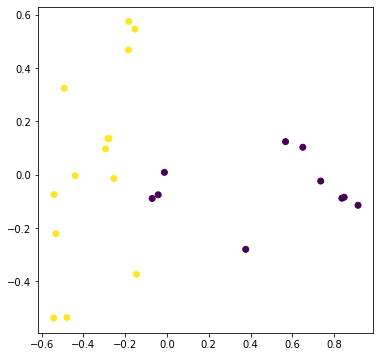

In [69]:
# Checking results with PCA
X_features = X_train[features_selected]
X_features = MinMaxScaler().fit_transform(X_features)
pca = PCA(n_components=2).fit(X_features)
X_pca = pca.transform(X_features)

print('Explained variance: ', pca.explained_variance_.sum())

_, ax = plt.subplots(figsize=(6,6))
ax.scatter(x = X_pca[:,0], y=X_pca[:,1], c=y_train)

In [70]:
from sklearn.manifold import TSNE

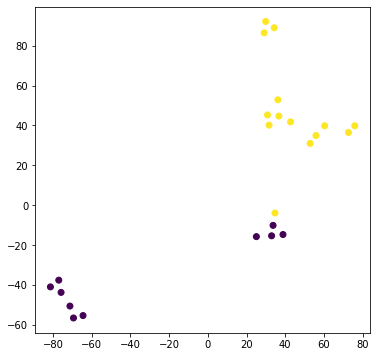

In [71]:
# Checking results with t-sne
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_features)


_, ax = plt.subplots(figsize=(6,6))
ax.scatter(x = X_embedded[:,0], y=X_embedded[:,1], c=y_train)